# General Introduction?

## Data acquisition
We downloaded curated sequences for CD-box and HACA-box RNAs from variuos species from the SNOPY database (http://snoopy.med.miyazaki-u.ac.jp/).
You can find the sequences in the "SNOPY_CDBOX_curated.fasta" and the "SNOPY_HACABOX_curated.fasta" files.
If working in JupyterLab you can easily inspect the .fasta files with the text editor by double-clicking the file in the "File Browser" pane on the left.
What do you notice? How could this be relevant later on?

## Data cleansing
Some species may have multiple copies of these RNAs and/or closely related species might have highly similar sequences. Having multiple highly similar or identical copies of a sequence can impede our models from learning a good generalization.
#### CD-HIT (http://weizhongli-lab.org/cd-hit/)
We will use cd-hit-est to cluster highly similar sequences and create sets of representative sequences for both classes. <br>
Verify cd-hit-est is installed and find out more about it by running "cd-hit-est -h". <br> You can run shell commands directly from jupyter code cells by prefixing the command with a "!".

In [27]:
!cd-hit-est -h

		====== CD-HIT version 4.8.1 (built on May 14 2019) ======

Usage: cd-hit-est [Options] 

Options

   -i	input filename in fasta format, required, can be in .gz format
   -j	input filename in fasta/fastq format for R2 reads if input are paired end (PE) files
 	 -i R1.fq -j R2.fq -o output_R1 -op output_R2 or
 	 -i R1.fa -j R2.fa -o output_R1 -op output_R2 
   -o	output filename, required
   -op	output filename for R2 reads if input are paired end (PE) files
   -c	sequence identity threshold, default 0.9
 	this is the default cd-hit's "global sequence identity" calculated as:
 	number of identical amino acids or bases in alignment
 	divided by the full length of the shorter sequence
   -G	use global sequence identity, default 1
 	if set to 0, then use local sequence identity, calculated as :
 	number of identical amino acids or bases in alignment
 	divided by the length of the alignment
 	NOTE!!! don't use -G 0 unless you use alignment coverage controls
 	see options -aL, -AL, -aS, -AS

#### CD-HIT parameters
Below are the (recommended) parameters for our clustering runs. Change if you like and run the cell please.

In [28]:
seq_identity = 0.9 # (-c)
word_size = 8 # recommended for 0.9 identity (-n)
threads = 0 # use all available CPUs (-T)
desc_len = 0 # keep description up until first white space (-d)

### Cluster CD-box sequences
Let's start by clustering the CD-box sequences. <br>
You can use variables in shell commands by enclosing them in curly braces i.e like this {variable}. <br>
You could define variables for the input file (-i) and output file (-o) parameters as well. <br>
Now run cd-hit-est using all of the defined parameters

In [29]:
cd_fasta_in = "SNOPY_CDBOX_curated.fasta" # (-i)
cd_clustered = "SNOPY_CDBOX_clustered.fasta" # (-o)

!cd-hit-est -i {cd_fasta_in} -o {cd_clustered} -c {seq_identity} -n {word_size} -T {threads} -d {desc_len}

Program: CD-HIT, V4.8.1 (+OpenMP), May 14 2019, 14:40:47
Command: cd-hit-est -i SNOPY_CDBOX_curated.fasta -o
         SNOPY_CDBOX_clustered.fasta -c 0.9 -n 8 -T 0 -d 0

Started: Tue Sep 17 12:13:31 2019
                            Output                              
----------------------------------------------------------------
total number of CPUs in the system is 4
Actual number of CPUs to be used: 4

total seq: 826
longest and shortest : 421 and 29
Total letters: 81726
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 4 X 12M = 48M
Table           : 2 X 1M = 2M
Miscellaneous   : 0M
Total           : 51M

Table limit with the given memory limit:
Max number of representatives: 3932523
Max number of word counting entries: 93604369

# comparing sequences from          0  to        826
---------- new table with      680 representatives

      826  finished        680  clusters

Approximated maximum memory consumption: 51M
writi

### Cluster HACA-box sequences
Repeat the steps for the HACA-box sequences

In [30]:
haca_fasta_in = "SNOPY_HACABOX_curated.fasta"
haca_clustered = "SNOPY_HACABOX_clustered.fasta"

!cd-hit-est -i {haca_fasta_in} -o {haca_clustered} -c {seq_identity} -n {word_size} -T {threads} -d {desc_len}

Program: CD-HIT, V4.8.1 (+OpenMP), May 14 2019, 14:40:47
Command: cd-hit-est -i SNOPY_HACABOX_curated.fasta -o
         SNOPY_HACABOX_clustered.fasta -c 0.9 -n 8 -T 0 -d 0

Started: Tue Sep 17 12:16:21 2019
                            Output                              
----------------------------------------------------------------
total number of CPUs in the system is 4
Actual number of CPUs to be used: 4

total seq: 571
longest and shortest : 1004 and 42
Total letters: 81189
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 4 X 12M = 49M
Table           : 2 X 1M = 2M
Miscellaneous   : 0M
Total           : 51M

Table limit with the given memory limit:
Max number of representatives: 3171132
Max number of word counting entries: 93550008

# comparing sequences from          0  to        571
---------- new table with      492 representatives

      571  finished        492  clusters

Approximated maximum memory consumption: 52M


# Data inspection

## Read in the sequences
We are now ready to read in the two sets of representative sequences. <br>
The output of cd-hit-est are .fasta files, a common data format for DNA/RNA/Protein sequence data. We can use the "parse" function from the SeqIO module from Biopython (https://biopython.org/wiki/SeqIO) to read sequences and identifiers from the fasta file.
(Since we are only dealing with two files following exactly the same format you could also easily roll your own fasta reader.) <br>
Create two pandas DataFrames (for each class) with the identifier as index and one column named "Seq" for the sequence. <br>
(You could f.e. put all sequences into a dictionary, which can then be read into a pandas DataFrame)<br> 


In [36]:
# read in seqs into two dicts
from Bio import SeqIO # to read fasta

dict_cd = {record.id: str(record.seq).upper() for record in SeqIO.parse(cd_clustered, "fasta")}
dict_haca = {record.id: str(record.seq).upper() for record in SeqIO.parse(haca_clustered, "fasta")}

In [40]:
# create two DataFrames from the dicts
import pandas as pd

df_cd = pd.DataFrame.from_dict(dict_cd, orient="index", columns=["Seq"])
df_haca = pd.DataFrame.from_dict(dict_haca, orient="index", columns=["Seq"])

In [38]:
df_cd

Seq
Arabidopsis_thaliana300001_SnoR1b      GGCGAGGATGAATAATGCTAAATTTCTGACACCTCTTGTATGAGGA...
Arabidopsis_thaliana300003_SnoR10-1    AGAAATGATGAGAAATCAGATAAATCTTAGGACACCTTCTGACACA...
Arabidopsis_thaliana300004_SnoR10-2    AAATATGATGATAATAATCAGTAAATATCTTAGGACACCTTCTGAC...
Arabidopsis_thaliana300006_SnoR101     GGGATACACTTGATCTCTGAACTTCACAGGTAAGTTCGCTTGTTGA...
Arabidopsis_thaliana300007_SnoR102     AGAAGTCAATAGACCAGACATTGTGGTAACACTCTCTTTCATGGCA...
Arabidopsis_thaliana300010_SnoR105     AGGGGATATGATGAATGGTAAAAACTCGCTTATATTGCGAGAAGAG...
Arabidopsis_thaliana300011_SnoR106     GAAAAGATGGGGTTGAGAATGTGATTTTGCTCTTCTTGATTCAAAC...
Arabidopsis_thaliana300012_SnoR107     AAATCTCTGCTTTTCACTGGGTATATATTAATTAGTCGTCTCTCTC...
Arabidopsis_thaliana300013_SnoR108     AGTTATAGGGGAAATGAGGAATGGTTATAATCTCGCTTTAATGCGT...
Arabidopsis_thaliana300015_SnoR11      TGGTTTTGAAGATAGGTTACCTTAATTCTCGGTTTATTAAGTGGAT...
Arabidopsis_thaliana300019_SnoR12-1a   TGAGGATGACGAAAAAATCATTCGGATTCCCTTTGAATTCCTCCGG...
Arabidopsis_thaliana300020_SnoR12-2    TGAGGGTGATGAAAAAAATCATTCGGATTCCCAATGATTCCCTTAC...
Arabidopsis_thaliana300021_SnoR12-1b   TGATGGTAAAAGATGACGAAAAAAATCGTTCGGATTCCCTTTGAAT...
Arabidopsis_thaliana300023_SnoR13-2    AGATCAGGTGATGAGGTAATACTGCAACAATATGATGGAGTAATCT...
Arabidopsis_thaliana300024_SnoR14-1    CGAGGTGACGATAGAAATTCACAGGTCTGTCAATCCACTGATATAT...
Arabidopsis_thaliana300025_SnoR14-2    GAAGTGACGATAAAGAATTCACAGTCTGTCAATCCACTGACAACAT...
Arabidopsis_thaliana300026_SnoR15      GCAGATGATGATTATCATAAAACAAATGGGTAATTTGCGACTGATA...
Arabidopsis_thaliana300027_SnoR16-1    GCAAATGATGAGTAGAATCTTATCCTACACACAGATGTATCAGTGT...
Arabidopsis_thaliana300028_SnoR16-2    GCAAATGAAGAATTGATTAATTTATGCTTAACCACTGATGAACAGT...
Arabidopsis_thaliana300029_SnoR17      CATAGTGATGAATTATATCACAATTGTCACTACCTCTGAGGCATAT...
Arabidopsis_thaliana300030_SnoR18a     AGATATGATGATGGAATTAGATTTCCCTATTGGTTTGATCGCCGTT...
Arabidopsis_thaliana300031_SnoR18b     TGAAGTGATGATTGAACTTTGTTTCCCTATTGGTTTGATCGCCGAT...
Arabidopsis_thaliana300032_SnoR19-1    AACAGTGATGAGTCAGTTTACAGACCTGTAATGATTGCGGTAATGA...
Arabidopsis_thaliana300034_SnoR20-1    GCCAGTGATGATTAGATTCAATGGTTGCTGAACATTCAATGTTGAA...
Arabidopsis_thaliana300035_SnoR20-2    AGGCTGATGAAGATTAGATATTAATGGTTACTGAAATTTCAATAAG...
Arabidopsis_thaliana300036_SnoR21b     GGCTGTGATGATTGAGAATGTCATGCACCACTCTGATTTTTTGTGC...
Arabidopsis_thaliana300041_SnoR22-2    ATGAGCTGATGATGAAAAAAAACAATTATCTTAGCGGATTTCAGTG...
Arabidopsis_thaliana300042_SnoR23-2    GATGCAATGATGAGATAAAAGCACGAAGAGTGTGAGAAGAGCAGTG...
Arabidopsis_thaliana300044_SnoR23-1    TGCGATGATGATAAAATAGCACGAAGGTGCGTGAAGGGCAGTGGAC...
Arabidopsis_thaliana300045_SnoR24c     TTAGCTGTGATGAGAAAGCTAACACGTAAGAAGAAGTACTCCTTTG...
...                                                                                  ...
Saccharomyces_cerevisiae300027_snR57   AAGCGTGATTATAAAAAATGATTTAAATATTTTTCTGAGGAAGTAT...
Saccharomyces_cerevisiae300029_snR39b  ATTTAGTGATGATACTGCCGATTCTGGCATTCCAAAAAGTGACTAG...
Saccharomyces_cerevisiae300030_snR71   GTTATATGATGATAACCTTCTCAGCTCACTCAGATCTTTTGATATG...
Saccharomyces_cerevisiae300032_snR68   TATCATGATGAGCATTTATTTTACTGCGTTATCGTATTGACGGGGG...
Saccharomyces_cerevisiae300033_snR67   TAACATGATGACTAAGTTGTCGCCCCAAGCGGATCTTTGAAATGAC...
Saccharomyces_cerevisiae300034_snR53   TTTGATGATGATTACACTCCATGCTAATCATGAACGTGTTCGATGT...
Saccharomyces_cerevisiae300036_snR69   GTTTATGATGAGACCACGTCCTTAGTGACAATGCTATAAACCCAGC...
Saccharomyces_cerevisiae300039_snR47   ATATATGATGATATCCTATAACAACAACAACATGAATTTCTTCGTC...
Saccharomyces_cerevisiae300045_snR50   TTAGAATGATGAAAGAGGTAGCAATTTGCAGCAGATTTTTCGTGAT...
Saccharomyces_cerevisiae300046_snR56   TTAACATGATGAAAAAATATATTAACACAGACCTGTACTGAACTTT...
Saccharomyces_cerevisiae300050_snR52   TACTATGATGAATGACATTAGCGTGAACAATCTCTGATACAAAATC...
Saccharomyces_cerevisiae300051_snR13   AGGAAGTTTTTTCCTTTTTATATGATGAATATGAGTGCATTTGGCT...
Saccharomyces_cerevisiae300052_snR63   TTTAATGATGAAGATTTTAATTTTCCGTTGGTCTATTAAGAACAGA...
Saccharomyces_cerevisiae300053_U14     TCACGGTGATGAAAGACTGGTTCCTTAACATTCGCAGTTTC

Add a column "Label" to both DataFrames containing the respective class label "CD-box" or "HACA-box"

In [41]:
df_cd["Label"] = "CD-box"
df_cd

Seq  \
Arabidopsis_thaliana300001_SnoR1b      GGCGAGGATGAATAATGCTAAATTTCTGACACCTCTTGTATGAGGA...   
Arabidopsis_thaliana300003_SnoR10-1    AGAAATGATGAGAAATCAGATAAATCTTAGGACACCTTCTGACACA...   
Arabidopsis_thaliana300004_SnoR10-2    AAATATGATGATAATAATCAGTAAATATCTTAGGACACCTTCTGAC...   
Arabidopsis_thaliana300006_SnoR101     GGGATACACTTGATCTCTGAACTTCACAGGTAAGTTCGCTTGTTGA...   
Arabidopsis_thaliana300007_SnoR102     AGAAGTCAATAGACCAGACATTGTGGTAACACTCTCTTTCATGGCA...   
Arabidopsis_thaliana300010_SnoR105     AGGGGATATGATGAATGGTAAAAACTCGCTTATATTGCGAGAAGAG...   
Arabidopsis_thaliana300011_SnoR106     GAAAAGATGGGGTTGAGAATGTGATTTTGCTCTTCTTGATTCAAAC...   
Arabidopsis_thaliana300012_SnoR107     AAATCTCTGCTTTTCACTGGGTATATATTAATTAGTCGTCTCTCTC...   
Arabidopsis_thaliana300013_SnoR108     AGTTATAGGGGAAATGAGGAATGGTTATAATCTCGCTTTAATGCGT...   
Arabidopsis_thaliana300015_SnoR11      TGGTTTTGAAGATAGGTTACCTTAATTCTCGGTTTATTAAGTGGAT...   
Arabidopsis_thaliana300019_SnoR12-1a   TGAGGATGACGAAAAAATCATTCGGATTCCCTTTGAATTCCTCCGG...   
Arabidopsis_thaliana300020_SnoR12-2    TGAGGGTGATGAAAAAAATCATTCGGATTCCCAATGATTCCCTTAC...   
Arabidopsis_thaliana300021_SnoR12-1b   TGATGGTAAAAGATGACGAAAAAAATCGTTCGGATTCCCTTTGAAT...   
Arabidopsis_thaliana300023_SnoR13-2    AGATCAGGTGATGAGGTAATACTGCAACAATATGATGGAGTAATCT...   
Arabidopsis_thaliana300024_SnoR14-1    CGAGGTGACGATAGAAATTCACAGGTCTGTCAATCCACTGATATAT...   
Arabidopsis_thaliana300025_SnoR14-2    GAAGTGACGATAAAGAATTCACAGTCTGTCAATCCACTGACAACAT...   
Arabidopsis_thaliana300026_SnoR15      GCAGATGATGATTATCATAAAACAAATGGGTAATTTGCGACTGATA...   
Arabidopsis_thaliana300027_SnoR16-1    GCAAATGATGAGTAGAATCTTATCCTACACACAGATGTATCAGTGT...   
Arabidopsis_thaliana300028_SnoR16-2    GCAAATGAAGAATTGATTAATTTATGCTTAACCACTGATGAACAGT...   
Arabidopsis_thaliana300029_SnoR17      CATAGTGATGAATTATATCACAATTGTCACTACCTCTGAGGCATAT...   
Arabidopsis_thaliana300030_SnoR18a     AGATATGATGATGGAATTAGATTTCCCTATTGGTTTGATCGCCGTT...   
Arabidopsis_thaliana300031_SnoR18b     TGAAGTGATGATTGAACTTTGTTTCCCTATTGGTTTGATCGCCGAT...   
Arabidopsis_thaliana300032_SnoR19-1    AACAGTGATGAGTCAGTTTACAGACCTGTAATGATTGCGGTAATGA...   
Arabidopsis_thaliana300034_SnoR20-1    GCCAGTGATGATTAGATTCAATGGTTGCTGAACATTCAATGTTGAA...   
Arabidopsis_thaliana300035_SnoR20-2    AGGCTGATGAAGATTAGATATTAATGGTTACTGAAATTTCAATAAG...   
Arabidopsis_thaliana300036_SnoR21b     GGCTGTGATGATTGAGAATGTCATGCACCACTCTGATTTTTTGTGC...   
Arabidopsis_thaliana300041_SnoR22-2    ATGAGCTGATGATGAAAAAAAACAATTATCTTAGCGGATTTCAGTG...   
Arabidopsis_thaliana300042_SnoR23-2    GATGCAATGATGAGATAAAAGCACGAAGAGTGTGAGAAGAGCAGTG...   
Arabidopsis_thaliana300044_SnoR23-1    TGCGATGATGATAAAATAGCACGAAGGTGCGTGAAGGGCAGTGGAC...   
Arabidopsis_thaliana300045_SnoR24c     TTAGCTGTGATGAGAAAGCTAACACGTAAGAAGAAGTACTCCTTTG...   
...                                                                                  ...   
Saccharomyces_cerevisiae300027_snR57   AAGCGTGATTATAAAAAATGATTTAAATATTTTTCTGAGGAAGTAT...   
Saccharomyces_cerevisiae300029_snR39b  ATTTAGTGATGATACTGCCGATTCTGGCATTCCAAAAAGTGACTAG...   
Saccharomyces_cerevisiae300030_snR71   GTTATATGATGATAACCTTCTCAGCTCACTCAGATCTTTTGATATG...   
Saccharomyces_cerevisiae300032_snR68   TATCATGATGAGCATTTATTTTACTGCGTTATCGTATTGACGGGGG...   
Saccharomyces_cerevisiae300033_snR67   TAACATGATGACTAAGTTGTCGCCCCAAGCGGATCTTTGAAATGAC...   
Saccharomyces_cerevisiae300034_snR53   TTTGATGATGATTACACTCCATGCTAATCATGAACGTGTTCGATGT...   
Saccharomyces_cerevisiae300036_snR69   GTTTATGATGAGACCACGTCCTTAGTGACAATGCTATAAACCCAGC...   
Saccharomyces_cerevisiae300039_snR47   ATATATGATGATATCCTATAACAACAACAACATGAATTTCTTCGTC...   
Saccharomyces_cerevisiae300045_snR50   TTAGAATGATGAAAGAGGTAGCAATTTGCAGCAGATTTTTCGTGAT...   
Saccharomyces_cerevisiae300046_snR56   TTAACATGATGAAAAAATATATTAACACAGACCTGTACTGAACTTT...   
Saccharomyces_cerevisiae300050_snR52   TACTATGATGAATGACATTAGCGTGAACAATCTCTGATACAAAATC...   
Saccharomyces_cerevisiae300051_snR13   AGGAAGTTTTTTCCTTTTTATATGATGAATATGAGTGCATTTGGCT...   
Saccharomyces_cerevisiae300052_snR63 

In [42]:
df_haca["Label"] = "HACA-box"
df_haca

Seq  \
Arabidopsis_thaliana300005_SnoR100       GAATGATTGTAGCATGGTACTGTGCACGGAAACTGAATCATGGGTT...   
Arabidopsis_thaliana300008_SnoR103       CGCAAGTATGTGTTTCTGCTGTAAATATGGACGTATAATGATATGT...   
Arabidopsis_thaliana300009_SnoR104       GGGGAGCATCAAAGAGTTGTGATGTTATCTGATACAATCTTCCTAA...   
Arabidopsis_thaliana300014_SnoR109       CGGCTGTAGCTAGATTGAATAAGAAGCTATCTGGCCGGTGGTCGCG...   
Arabidopsis_thaliana300016_SnoR110       GCTAAATTTAGTGCCGCCTTGTCTTTTCAAGTTTTCTCCTTTTGTA...   
Arabidopsis_thaliana300017_SnoR111       AAAATGGGGCAAGAGAGAGTAACGGTGTCTCTGAGTCCTTGATGAA...   
Arabidopsis_thaliana300018_SnoR112       TTGGATTGGAAATATGTTCCTTATCGGCTCGTTCAATATTGAAGCA...   
Arabidopsis_thaliana300080_SnoR5a        GCCTATGGTATCTGATGTCCAAAGTTTGATAATTGTGTTTGGACAT...   
Arabidopsis_thaliana300099_SnoR72        GAATCTCCTACAGGTCTTGCGACACAGTTTGCTTTTGATTTGATAA...   
Arabidopsis_thaliana300104_SnoR73        GTGTTGGTATTATATTCTTGTACCCACACTCTACAATTGATAAGCT...   
Arabidopsis_thaliana300105_SnoR74-2      GCAGGGTTCTGTTTTATATAACAGACCTCACGTAAATGTCAGGAAA...   
Arabidopsis_thaliana300106_SnoR74-1      GAAAAAGCAGAGTTCTGTTGCAATTTGACAGATCTCACGTATACTT...   
Arabidopsis_thaliana300108_h-127bSnoR76  GATTTTTTTATAATTTGCAGAGTTGTTCTTCCTTCTTTGCTGATTA...   
Arabidopsis_thaliana300109_SnoR77        AGGCAACCTACTTGTTAATAAAACAATGACATGAGAGGTGTTTAAC...   
Arabidopsis_thaliana300113_SnoR78-1      TGCCAAATTTGTGTCGGAAGATGACAAGATTGATTTTGCCTCTCCA...   
Arabidopsis_thaliana300114_SnoR78-2      GCAAGATAGGTTATAATTTGTACCAATTTTGTGTCGGAAGATGACA...   
Arabidopsis_thaliana300115_SnoR79        GTTTGAACTGTTACATCTCTGGTAAAGAAAAAAGAGAGAAGGAAAG...   
Arabidopsis_thaliana300118_SnoR80        ACCAATTCTGAGGGATAAAAACAGTTCCTTCAGGTATAATGGCTTG...   
Arabidopsis_thaliana300119_SnoR81        TATATCTCTCCTGACATCGAATAATTCAGATATTAATGCTTGTGTT...   
Arabidopsis_thaliana300120_SnoR82        GCTTCTTTGATTGGGTCAAGATATTCACGATCCAATCAATTTTATG...   
Arabidopsis_thaliana300121_SnoR83        ATCCCAGCTAAGTTTGATGAAGTACTTATCTGATTCATGTGAGGCC...   
Arabidopsis_thaliana300122_SnoR84        CATCTCTGCTCAATCCTTACACCAAATTTTGATGGTATAAGAGGAT...   
Arabidopsis_thaliana300124_SnoR86        GAGCAATGACGTCAAAATAAAAATGGCGTAAGTTGCCTTGAAGGTT...   
Arabidopsis_thaliana300125_SnoR87          CGAGCTGAAATGTGCTCTCACTTTTGTGGCTGCTAACTGTACACAGT   
Arabidopsis_thaliana300126_SnoR88-2      GATTCGTTCCCTTGAAGCAATATTAATCGTGTTGCTCTCGTTCTCT...   
Arabidopsis_thaliana300127_SnoR88-1      GATTCGTTCCCTTGAAGCAAAATCAATCGTGTTGCTTTCGTTATTT...   
Arabidopsis_thaliana300131_SnoR90        GAGTCTTTTGGCTATGATTAGCTTTGAATGCTAATGGACTGACATC...   
Arabidopsis_thaliana300132_SnoR91               AATTTCTCATCTTTCCAGATGATTTTCTTGAATGGTACATTT   
Arabidopsis_thaliana300133_SnoR92        ACGGGTTTCTTTGTGCTTTCTCTGTGTTTTGTGTATTTTTTATACT...   
Arabidopsis_thaliana300134_SnoR93        GTGAGATTCAATTTTCGATCTAATGTTACTAATTTTAGCCTTTAGG...   
...                                                                                    ...   
Mus_musculus300900_SNORA62               CCTGCACATTGTTAGAGCTTGGAGTTGAGGTCACACGCTGGTCGAT...   
Saccharomyces_cerevisiae300001_snR85     TACTAGCACATATGTCAAATTCCTAATTAACGTTTTTTATATTCAT...   
Saccharomyces_cerevisiae300002_snR84     ATTGCACAACTTAAGTTTGTCGAGGATCATTTTTTTGAACTGAATC...   
Saccharomyces_cerevisiae300005_snR43     CACTCCTGTTTCTGCCTCATGTCTTTTAAAACGCTTCCACGGGACA...   
Saccharomyces_cerevisiae300006_snR32     AACATCATAATTATATCGCGAATGTACTACTAGTATATGCAGTTTT...   
Saccharomyces_cerevisiae300007_snR81     AGGTTAGGGACTGCAAAAGAAGCGGCGAGGCAGCCCACATCAAGTG...   
Saccharomyces_cerevisiae300009_snR36     TTGCCCTGTGCCTCGCTCGGTTGTTAATTGCCAATATTACGATCTT...   
Saccharomyces_cerevisiae300010_snR49     ATGGGACTTTATCTCCATGACTATGCCATTTCTAGGTAGCCTATGG...   
Saccharomyces_cerevisiae300020_snR82     ATGGCTCTTCAACACATTTCAACATGTTCAAGTAATTTGTGTTAGT...   
Saccharomyces_cerevisiae300021_snR189    AACAAAATAATTTACATTCCAAGGACCGGTATTATTGTAGGGGATT...   
Saccharomyces_cerevisiae300022_snR42     ATAACAATTTGTGATGCTTTAGGGAGCCTATTGTTTGATGGTTTAT...   
Saccharomyces_cerevisiae300023_snR10     AACG

Combine both DataFrames to create our complete data set. (Save the resulting DataFrame to a csv file)

In [47]:
df_all = pd.concat([df_cd, df_haca], axis=0)
df_all

Seq  \
Arabidopsis_thaliana300001_SnoR1b      GGCGAGGATGAATAATGCTAAATTTCTGACACCTCTTGTATGAGGA...   
Arabidopsis_thaliana300003_SnoR10-1    AGAAATGATGAGAAATCAGATAAATCTTAGGACACCTTCTGACACA...   
Arabidopsis_thaliana300004_SnoR10-2    AAATATGATGATAATAATCAGTAAATATCTTAGGACACCTTCTGAC...   
Arabidopsis_thaliana300006_SnoR101     GGGATACACTTGATCTCTGAACTTCACAGGTAAGTTCGCTTGTTGA...   
Arabidopsis_thaliana300007_SnoR102     AGAAGTCAATAGACCAGACATTGTGGTAACACTCTCTTTCATGGCA...   
Arabidopsis_thaliana300010_SnoR105     AGGGGATATGATGAATGGTAAAAACTCGCTTATATTGCGAGAAGAG...   
Arabidopsis_thaliana300011_SnoR106     GAAAAGATGGGGTTGAGAATGTGATTTTGCTCTTCTTGATTCAAAC...   
Arabidopsis_thaliana300012_SnoR107     AAATCTCTGCTTTTCACTGGGTATATATTAATTAGTCGTCTCTCTC...   
Arabidopsis_thaliana300013_SnoR108     AGTTATAGGGGAAATGAGGAATGGTTATAATCTCGCTTTAATGCGT...   
Arabidopsis_thaliana300015_SnoR11      TGGTTTTGAAGATAGGTTACCTTAATTCTCGGTTTATTAAGTGGAT...   
Arabidopsis_thaliana300019_SnoR12-1a   TGAGGATGACGAAAAAATCATTCGGATTCCCTTTGAATTCCTCCGG...   
Arabidopsis_thaliana300020_SnoR12-2    TGAGGGTGATGAAAAAAATCATTCGGATTCCCAATGATTCCCTTAC...   
Arabidopsis_thaliana300021_SnoR12-1b   TGATGGTAAAAGATGACGAAAAAAATCGTTCGGATTCCCTTTGAAT...   
Arabidopsis_thaliana300023_SnoR13-2    AGATCAGGTGATGAGGTAATACTGCAACAATATGATGGAGTAATCT...   
Arabidopsis_thaliana300024_SnoR14-1    CGAGGTGACGATAGAAATTCACAGGTCTGTCAATCCACTGATATAT...   
Arabidopsis_thaliana300025_SnoR14-2    GAAGTGACGATAAAGAATTCACAGTCTGTCAATCCACTGACAACAT...   
Arabidopsis_thaliana300026_SnoR15      GCAGATGATGATTATCATAAAACAAATGGGTAATTTGCGACTGATA...   
Arabidopsis_thaliana300027_SnoR16-1    GCAAATGATGAGTAGAATCTTATCCTACACACAGATGTATCAGTGT...   
Arabidopsis_thaliana300028_SnoR16-2    GCAAATGAAGAATTGATTAATTTATGCTTAACCACTGATGAACAGT...   
Arabidopsis_thaliana300029_SnoR17      CATAGTGATGAATTATATCACAATTGTCACTACCTCTGAGGCATAT...   
Arabidopsis_thaliana300030_SnoR18a     AGATATGATGATGGAATTAGATTTCCCTATTGGTTTGATCGCCGTT...   
Arabidopsis_thaliana300031_SnoR18b     TGAAGTGATGATTGAACTTTGTTTCCCTATTGGTTTGATCGCCGAT...   
Arabidopsis_thaliana300032_SnoR19-1    AACAGTGATGAGTCAGTTTACAGACCTGTAATGATTGCGGTAATGA...   
Arabidopsis_thaliana300034_SnoR20-1    GCCAGTGATGATTAGATTCAATGGTTGCTGAACATTCAATGTTGAA...   
Arabidopsis_thaliana300035_SnoR20-2    AGGCTGATGAAGATTAGATATTAATGGTTACTGAAATTTCAATAAG...   
Arabidopsis_thaliana300036_SnoR21b     GGCTGTGATGATTGAGAATGTCATGCACCACTCTGATTTTTTGTGC...   
Arabidopsis_thaliana300041_SnoR22-2    ATGAGCTGATGATGAAAAAAAACAATTATCTTAGCGGATTTCAGTG...   
Arabidopsis_thaliana300042_SnoR23-2    GATGCAATGATGAGATAAAAGCACGAAGAGTGTGAGAAGAGCAGTG...   
Arabidopsis_thaliana300044_SnoR23-1    TGCGATGATGATAAAATAGCACGAAGGTGCGTGAAGGGCAGTGGAC...   
Arabidopsis_thaliana300045_SnoR24c     TTAGCTGTGATGAGAAAGCTAACACGTAAGAAGAAGTACTCCTTTG...   
...                                                                                  ...   
Mus_musculus300900_SNORA62             CCTGCACATTGTTAGAGCTTGGAGTTGAGGTCACACGCTGGTCGAT...   
Saccharomyces_cerevisiae300001_snR85   TACTAGCACATATGTCAAATTCCTAATTAACGTTTTTTATATTCAT...   
Saccharomyces_cerevisiae300002_snR84   ATTGCACAACTTAAGTTTGTCGAGGATCATTTTTTTGAACTGAATC...   
Saccharomyces_cerevisiae300005_snR43   CACTCCTGTTTCTGCCTCATGTCTTTTAAAACGCTTCCACGGGACA...   
Saccharomyces_cerevisiae300006_snR32   AACATCATAATTATATCGCGAATGTACTACTAGTATATGCAGTTTT...   
Saccharomyces_cerevisiae300007_snR81   AGGTTAGGGACTGCAAAAGAAGCGGCGAGGCAGCCCACATCAAGTG...   
Saccharomyces_cerevisiae300009_snR36   TTGCCCTGTGCCTCGCTCGGTTGTTAATTGCCAATATTACGATCTT...   
Saccharomyces_cerevisiae300010_snR49   ATGGGACTTTATCTCCATGACTATGCCATTTCTAGGTAGCCTATGG...   
Saccharomyces_cerevisiae300020_snR82   ATGGCTCTTCAACACATTTCAACATGTTCAAGTAATTTGTGTTAGT...   
Saccharomyces_cerevisiae300021_snR189  AACAAAATAATTTACATTCCAAGGACCGGTATTATTGTAGGGGATT...   
Saccharomyces_cerevisiae300022_snR42   ATAACAATTTGTGATGCTTTAGGGAGCCTATTGTTTGATGGTTTAT...   
Saccharomyces_cerevisiae300023_snR10   AACGCAAATTTAACAGCCATTCGTAACACGTACAGTATCTCGTCGA...   
Saccharomyces_cerevisiae300028_snR80 

Let's add some features to generate a first impression of our data. <br>
Add a column "Length" containing the length of the sequence

In [48]:
df_all["Length"] = df_all.Seq.map(len)

Two commonly used features for DNA sequences are the "GC content" and the "ATGC ratio".<br>
The GC content is the percentage of "G"s or "C"s in the whole sequence. <br>
The ATGC ratio is the ratio of "A"s and "T"s to "G"s and "C"s. <br>
Create two columns "GC_content" and "ATGC_ratio" containing the respective feature.

In [49]:
df_all["GC_content"] = df_all.Seq.map( lambda x: (x.count("G") + x.count("C")) / len(x) )
df_all["ATGC_ratio"] = df_all.Seq.map( lambda x: (x.count("A") + x.count("T")) / (x.count("G") + x.count("C")) )

Let's generate a first overview of the data using the DataFrame's describe() method

In [52]:
df_all.describe()

Length   GC_content   ATGC_ratio
count  1172.000000  1172.000000  1172.000000
mean    118.895051     0.417389     1.472921
std      57.874464     0.073975     0.449738
min      29.000000     0.220779     0.380435
25%      79.000000     0.364123     1.149734
50%     115.000000     0.415485     1.406829
75%     135.250000     0.465174     1.746324
max    1004.000000     0.724409     3.529412

We are also interested in the differences between our classes.<br>
<b>Generate a class-wise description using groupby() and describe()<b>

In [84]:
df_all.groupby("Label").describe()

Length                                                           GC_content                                                                       ATGC_ratio                                                                      
          count        mean        std   min    25%    50%    75%     max      count      mean       std       min       25%       50%       75%       max      count      mean       std       min       25%       50%       75%       max
Label                                                                                                                                                                                                                                      
CD-box    680.0  100.876471  50.334428  29.0   73.0   82.0  101.0   421.0      680.0  0.404823  0.072311  0.220779  0.354430  0.402306  0.450704  0.711340      680.0  1.550262  0.465136  0.405797  1.218750  1.485667  1.821429  3.529412
HACA-box  492.0  143.798780  58.424932  42.0  128.0  134.0  140.0  1004.0      492.0  0.434756  0.072796  0.241611  0.377281  0.431595  0.483737  0.724409      492.0  1.366027  0.404303  0.380435  1.067243  1.316986  1.650543  3.138889

To get a visual impression of the distribution of the features in our data we can use the pairplot() function form the seaborn visualization library (https://seaborn.pydata.org/) <br>
Generate a pair plot for the DataFrame. What is easily visible using the plot?

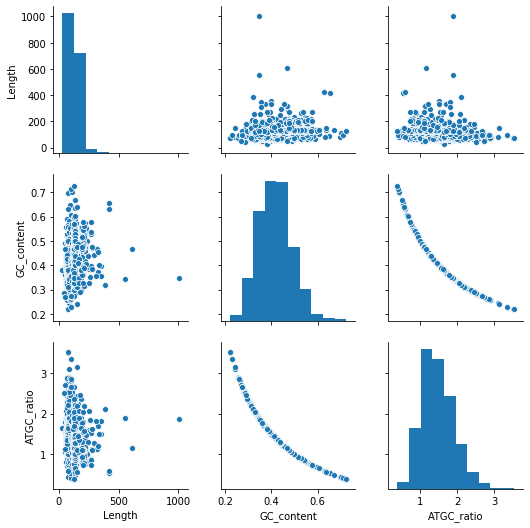

In [60]:
import seaborn as sns # Seaborn visualization library (for pairs plot)
sns.pairplot(df_all)

Again we are also interested in the differences between the two classes.<br>
<b>Generate a pair plot colored by class (Label) (https://seaborn.pydata.org/generated/seaborn.pairplot.html)<b>

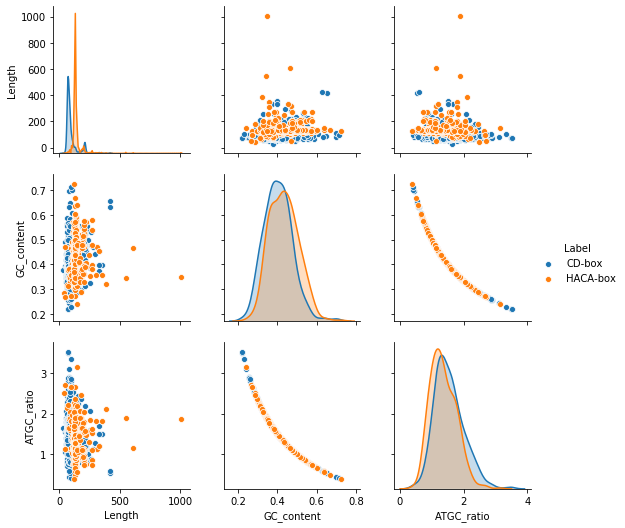

In [61]:
sns.pairplot(df_all, hue = 'Label')

Let's save the DataFrame to a csv in case we need it later

In [ ]:
df_all.to_csv("df_ALL.csv")

We already noticed above (using describe) that we have a few more CD-box sequences than HACA-box sequences. <br>
To balance our dataset we can use the "resample" function from scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html).<br>
<b>Downsample the larger class to the size of the smaller class and create a new balanced DataFrame.</b>

In [77]:
from sklearn.utils import resample
rnd_seed=42

# We are going to remove the randomly selected sequences
df_cd_ds = resample(df_cd, 
                    replace=False,          # sample without replacement
                    n_samples=len(df_cd) - len(df_haca), # class size difference
                    random_state=rnd_seed)  # fix seed for reproducible results

df_balanced = df_all.drop(index=df_cd_ds.index) # drop the selected sequences
df_balanced.Label.value_counts()

HACA-box    492
CD-box      492
Name: Label, dtype: int64

The sampling procedure should leave us with a representative sample, but let us check that we didn't end up with a skewed sample anyways.<br>
<b>Use groupby(), describe() and element-wise substraction to analyse the differences between the balanced and the original data.</b>

In [92]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

df_balanced.groupby("Label").describe() - df_all.groupby("Label").describe()

Length                                                 GC_content                                                           ATGC_ratio                                                            
          count      mean       std   min   25%  50%   75%  max      count     mean      std  min       25%       50%       75%  max      count      mean       std  min       25%       50%       75%  max
Label                                                                                                                                                                                                      
CD-box   -188.0  1.038164  1.554895  22.0  0.75  0.0  1.25  0.0     -188.0  0.00375  0.00058  0.0  0.003204  0.004344  0.002373  0.0     -188.0 -0.024679 -0.011034  0.0 -0.011619 -0.026528 -0.025275  0.0
HACA-box    0.0  0.000000  0.000000   0.0  0.00  0.0  0.00  0.0        0.0  0.00000  0.00000  0.0  0.000000  0.000000  0.000000  0.0        0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.0

In [93]:
pd.reset_option("display")

Let's save the balanced DataFrame to a csv in case we need it later

In [80]:
df_balanced.to_csv("df_balanced.csv")

## A first simple classifier
We already noticed using the pair plot that the sequence length distributions of the two classes seem to be quite different. Can we train a simple classifier with only the features we already constructed? The performance of this classifier can then be used to establish a baseline for our upcoming more complex models (i.e CNNs).<br>
Wait! First things first. We need to split the data into a set used for training and a set used for testing.<br>
<b>Use sklearn's train_test_split to create sets of training and test data and corresponding sets of labels. Use an 80/20 split.</b>

In [94]:
from sklearn.model_selection import train_test_split
rnd_seed=42

xTrain, xTest, yTrain, yTest = train_test_split( df_balanced, df_balanced.Label, test_size=0.2, random_state=rnd_seed )

In [95]:
print(yTrain.value_counts())
print(yTest.value_counts())

HACA-box    394
CD-box      393
Name: Label, dtype: int64
CD-box      99
HACA-box    98
Name: Label, dtype: int64


Now we are going to train a "Naive Bayes" classifier using our features (https://scikit-learn.org/stable/modules/naive_bayes.html) <br>
<b>Fit a GaussianNB classifier to the training dataset and generate predictions for the test dataset. Does it make sense to include all of the features?<b>

In [99]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB() # create classifier
gnb.fit(xTrain[["Length","GC_content"]], yTrain) # train using only length and GC
yPred = gnb.predict(xTest[["Length","GC_content"]]) # generate predictions

yPred

array(['HACA-box', 'CD-box', 'HACA-box', 'HACA-box', 'CD-box', 'HACA-box',
       'HACA-box', 'HACA-box', 'HACA-box', 'CD-box', 'CD-box', 'HACA-box',
       'HACA-box', 'HACA-box', 'HACA-box', 'CD-box', 'CD-box', 'HACA-box',
       'CD-box', 'CD-box', 'CD-box', 'CD-box', 'HACA-box', 'HACA-box',
       'HACA-box', 'CD-box', 'CD-box', 'CD-box', 'CD-box', 'CD-box',
       'CD-box', 'CD-box', 'CD-box', 'HACA-box', 'HACA-box', 'HACA-box',
       'HACA-box', 'CD-box', 'CD-box', 'CD-box', 'HACA-box', 'CD-box',
       'CD-box', 'CD-box', 'CD-box', 'CD-box', 'HACA-box', 'CD-box',
       'HACA-box', 'CD-box', 'HACA-box', 'HACA-box', 'CD-box', 'HACA-box',
       'CD-box', 'HACA-box', 'HACA-box', 'HACA-box', 'HACA-box', 'CD-box',
       'CD-box', 'CD-box', 'CD-box', 'CD-box', 'CD-box', 'CD-box',
       'CD-box', 'CD-box', 'CD-box', 'HACA-box', 'CD-box', 'CD-box',
       'CD-box', 'HACA-box', 'HACA-box', 'CD-box', 'CD-box', 'CD-box',
       'HACA-box', 'CD-box', 'CD-box', 'CD-box', 'CD-box', 'HACA-

To assess the quality of our prediction scikit-learn provides us with many different metrics. (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)<br>
<b>Use sklearn.metrics to print out the accuracy_score and the matthews_corrcoef for the generated predictions.</b> (Are these good choices for our problem?)

In [103]:
from sklearn import metrics

print("Accuracy:", metrics.accuracy_score(yTest, yPred))
print("MCC:", metrics.matthews_corrcoef(yTest, yPred))

Accuracy: 0.700507614213198
MCC: 0.4065869094085616


Scikit-learn also provides a classification report which includes commonly used metrics (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report)<br>
<b>Print out the classification report for the predictions<b>

In [102]:
from sklearn.metrics import classification_report

print(classification_report(yTest, yPred))

              precision    recall  f1-score   support

      CD-box       0.67      0.79      0.73        99
    HACA-box       0.74      0.61      0.67        98

    accuracy                           0.70       197
   macro avg       0.71      0.70      0.70       197
weighted avg       0.71      0.70      0.70       197



Another common way of looking at the confusion of a classifier is the confusion matrix.<br>
<b>Use scikit-learn to create a confusion matrix for the predictions and print it</b>

In [111]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(yTest, yPred)
conf_mat

array([[78, 21],
       [38, 60]])

Not that pretty, is it? Let's use seaborn and matplotlib to create a matrix that is a bit more appealing to the eye.<br>
<b>Adjust the code below to generate a pretty confusion matrix<b>

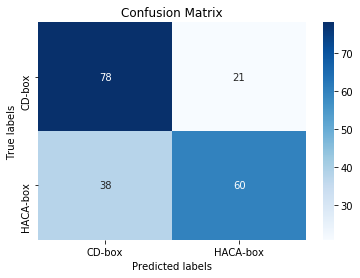

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt  

classes = ["CD-box", "HACA-box"]
df_confmat = pd.DataFrame(conf_mat, columns=df_balanced.Label.unique(), index=df_balanced.Label.unique())

ax= plt.subplot()

sns.heatmap(df_confmat, annot=True, ax=ax, cmap="Blues"); #annot=True to annotate cells

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')

plt.show()

So now that we have establish a (maybe crude) baseline for our classification problem let's create a simple CNN and find out whether this will improve our scores in the next notebook "02_first_CNN"